In [1]:
import sys, os
sys.path.append('..')
from Data.TimeSeries import *

from Data import factors
import Quandl
import pandas as pd
import matplotlib

import cvxopt as opt
from cvxopt import blas, solvers


%matplotlib inline

## 0. downloading data
Download the ETF data

In [466]:
tickers = ['GOOG/NYSE_SPY', #S&P 500 ETF 
           'GOOG/AMEX_EWJ', # iShares MSCI Japan ETF
           'GOOG/NYSE_IEV', # iShares Europe ETF
           #'GOOG/NYSE_VWO', # Vanguard Emerging Market Stock ETF
           
           #'GOOG/NYSE_VNQ', # Vanguard MSCI US Reits
           'GOOG/NYSE_IYR', # iShares U.S. Real Estate ETF
           'GOOG/NYSE_RWX', # SPDR DJ Wilshire Intl Real Estate ETF
           
           'GOOG/NYSEARCA_TLT',  # 20 Years Treasury ETF
           'GOOG/NYSEARCA_TLH',  # 15-20 Years Treasury
           
           'GOOG/AMEX_GSG', # GSCI Commodity-Indexed Trust Fund
           'GOOG/NYSEARCA_GLD',  # SPDR Gold ETF
           
          ]

settings = Settings()
dp = TimeSeries(settings).get_agg_data(tickers)
dp

<class 'pandas.core.panel.Panel'>
Dimensions: 9 (items) x 5040 (major_axis) x 6 (minor_axis)
Items axis: GOOG/AMEX_EWJ to GOOG/NYSE_SPY
Major_axis axis: 1996-03-18 00:00:00+00:00 to 2016-03-04 00:00:00+00:00
Minor_axis axis: open to price

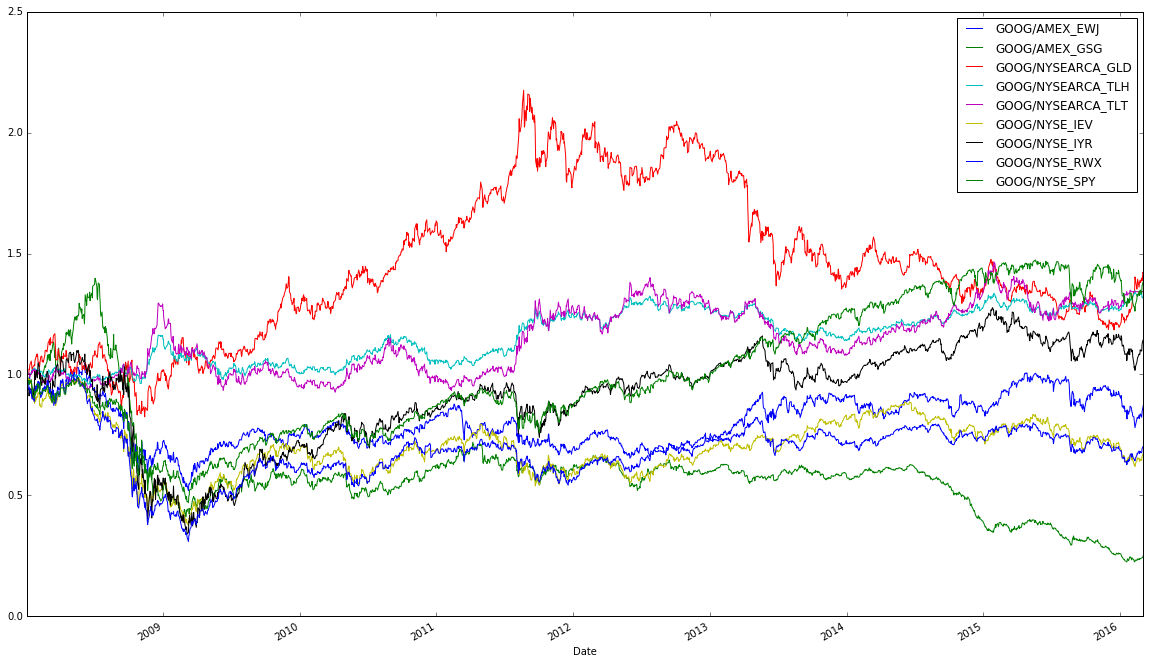

In [311]:
dp = dp.fillna(method='pad', axis=0)
dp = dp.fillna(method='bfill', axis=0)
dp = dp[:,'2008-01-01'::,:]
#dp[:, :,'price'].plot(figsize=[20,10])
df_rets = dp[:,:,'price'].pct_change().dropna()
(1+df_rets).cumprod().plot(figsize=[20,12])

# Adaptive Asset Allocation (AAA)

In [295]:
import numpy as np
import zipline 
from zipline.api import (add_history, history, set_slippage, 
                         slippage, set_commission, commission, 
                         order_target_percent) 

from zipline import TradingAlgorithm 

def initialize(context): 
    ''' Called once at the very beginning of a backtest (and live trading). 
    Use this method to set up any bookkeeping variables. The context object 
    is passed to all the other methods in your algorithm. Parameters context: 
    An initialized and empty Python dictionary that has been augmented so 
    that properties can be accessed using dot notation as well as the 
    traditional bracket notation. Returns None ''' 
    #Register history container to keep a window of the last 100 prices. 
    add_history(100, '1d', 'price') 
    # Turn off the slippage model 
    set_slippage(slippage.FixedSlippage(spread=0.0)) 
    # Set the commission model (Interactive Brokers Commission) 
    set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0)) 
    context.tick = 0
    
def handle_data(context, data): 
    ''' Called when a market event occurs for any of the algorithm's securities. 
    Parameters data: A dictionary keyed by security id containing the current 
    state of the securities in the algo's universe. context: The same context 
    object from the initialize function. Stores the up to date portfolio as 
    well as any state variables defined. Returns None ''' 
    # Allow history to accumulate 100 days of prices before trading 
    # and rebalance every day thereafter. 
    context.tick += 1 
    if context.tick < 100: 
        return 
    if context.tick % 60 != 0:
        return 
    
    
    # Get rolling window of past prices and compute returns 
    prices = history(100, '1d', 'price').dropna() 
    returns = prices.pct_change().dropna() 
    try: 
        # Perform Markowitz-style portfolio optimization 
        weights, _, _ = optimal_portfolio(returns.T) 
        # Rebalance portfolio accordingly 
        for stock, weight in zip(prices.columns, weights): 
            order_target_percent(stock, weight) 
    except ValueError as e: 
        # Sometimes this error is thrown 
        # ValueError: Rank(A) < p or Rank([P; A; G]) < n 
        pass
    


##  1.  10 assets, Equal Weight, Rebalanced Monthly


In [483]:
ret_ports = pd.DataFrame()

In [484]:
def portfolio_1(returns): 
    n = len(returns) 
    wt = opt.matrix(1.0/n, (n, 1))
    return np.asarray(wt)

def initialize(context):
    add_history(30, '1d', 'price') 
    set_slippage(slippage.FixedSlippage(spread=0.005)) 
    set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0)) 
    context.tick = 0
    
def handle_data(context, data): 
    rebalance_period = 20
    
    context.tick += 1 
    if context.tick % rebalance_period != 0:
        return 
    
    
    # Get rolling window of past prices and compute returns 
    prices = history(30, '1d', 'price').dropna() 
    returns = prices.pct_change().dropna() 
    try: 
        # Perform Markowitz-style portfolio optimization 
        weights = portfolio_1(returns.T) 
        # Rebalance portfolio accordingly 
        for stock, weight in zip(prices.columns, weights): 
            order_target_percent(stock, weight) 
    except ValueError as e: 
        # Sometimes this error is thrown 
        # ValueError: Rank(A) < p or Rank([P; A; G]) < n 
        pass

    
# Instantinate algorithm 
algo1 = TradingAlgorithm(initialize=initialize, 
                        handle_data=handle_data) 
# Run algorithm 
results = algo1.run(dp.dropna())
ret_ports[1] = results.portfolio_value

## Portfolio 2: Equal Volatility Weight, Rebalanced Monthly
with the 10 assets. Each asset has 1% daily vol (60 days moving vol). And no asset has over 10% of the portfolio 

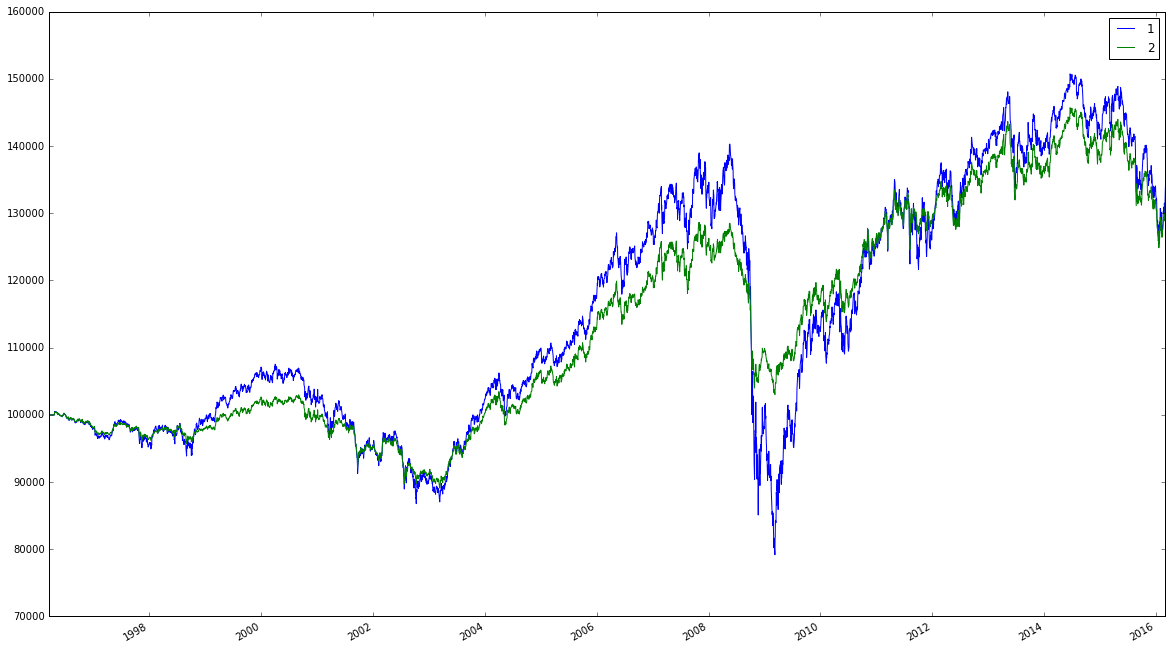

In [485]:
def portfolio_2(returns): 
    vol = np.std(returns, axis=1)
    vol_target = 0.01
    wt = vol_target / vol * 0.1
    wt[wt > 0.1] = 0.1
    return np.asarray(wt)

def initialize(context):
    add_history(60, '1d', 'price') 
    set_slippage(slippage.FixedSlippage(spread=0.0)) 
    set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0)) 
    context.tick = 0
    
def handle_data(context, data): 
    rebalance_period = 20
    
    context.tick += 1 
    if context.tick % rebalance_period != 0:
        return 
    
    
    # Get rolling window of past prices and compute returns 
    prices = history(60, '1d', 'price').dropna() 
    returns = prices.pct_change().dropna() 
    try: 
        # Perform Markowitz-style portfolio optimization 
        weights = portfolio_2(returns.T) 
        # Rebalance portfolio accordingly 
        for stock, weight in zip(prices.columns, weights): 
            order_target_percent(stock, weight) 
    except ValueError as e: 
        # Sometimes this error is thrown 
        # ValueError: Rank(A) < p or Rank([P; A; G]) < n 
        pass

    
# Instantinate algorithm 
algo2 = TradingAlgorithm(initialize=initialize, 
                        handle_data=handle_data) 
# Run algorithm 
results = algo2.run(dp.dropna())
ret_ports[2] = results.portfolio_value
ret_ports.plot(figsize=[20,12])

## Portfolio 3: Top 5 in 6 month momentum, each position = 20%


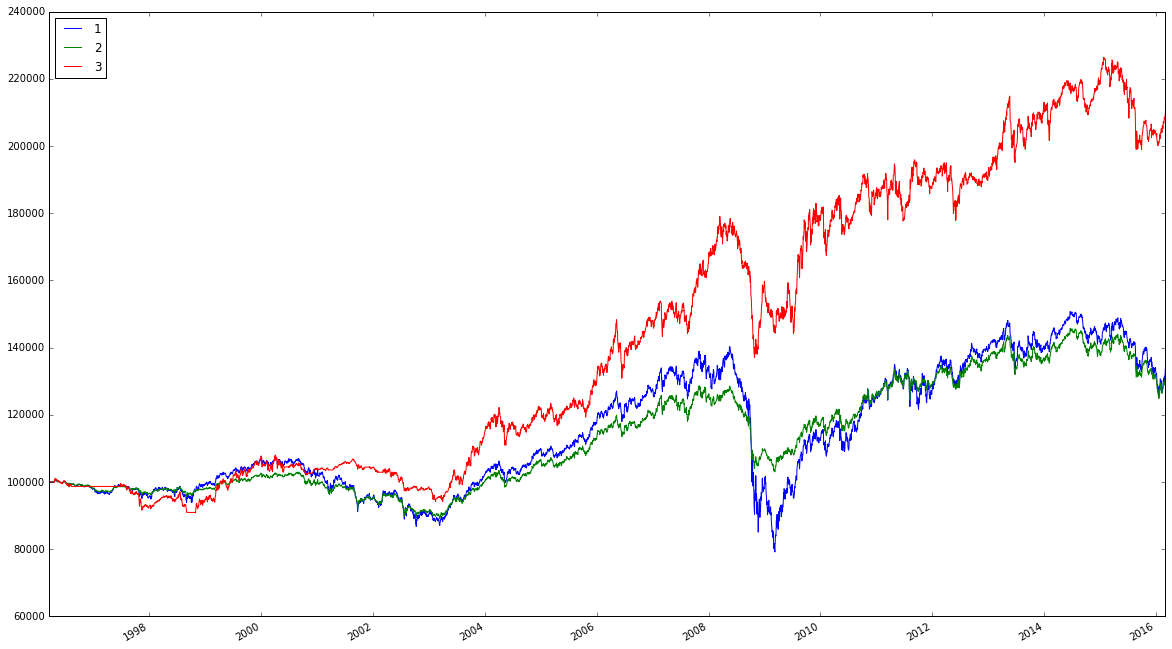

In [486]:
def portfolio_3(returns): 
    mom = returns.sum(axis=1)
    wt = (mom > np.median(mom)) * 0.2
    return np.asarray(wt)

def initialize(context):
    add_history(120, '1d', 'price') 
    set_slippage(slippage.FixedSlippage(spread=0.0)) 
    set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0)) 
    context.tick = 0
    
def handle_data(context, data): 
    rebalance_period = 20
    
    context.tick += 1 
    if context.tick % rebalance_period != 0:
        return 
    
    
    # Get rolling window of past prices and compute returns 
    prices = history(120, '1d', 'price').dropna() 
    returns = prices.pct_change().dropna() 
    try: 
        # Perform Markowitz-style portfolio optimization 
        weights = portfolio_3(returns.T) 
        # Rebalance portfolio accordingly 
        for stock, weight in zip(prices.columns, weights): 
            order_target_percent(stock, weight) 
    except ValueError as e: 
        # Sometimes this error is thrown 
        # ValueError: Rank(A) < p or Rank([P; A; G]) < n 
        pass

    
# Instantinate algorithm 
algo3 = TradingAlgorithm(initialize=initialize, 
                        handle_data=handle_data) 
# Run algorithm 
results = algo3.run(dp.dropna())
ret_ports[3] = results.portfolio_value
ret_ports.plot(figsize=[20,12])

## Portfolio 4: 

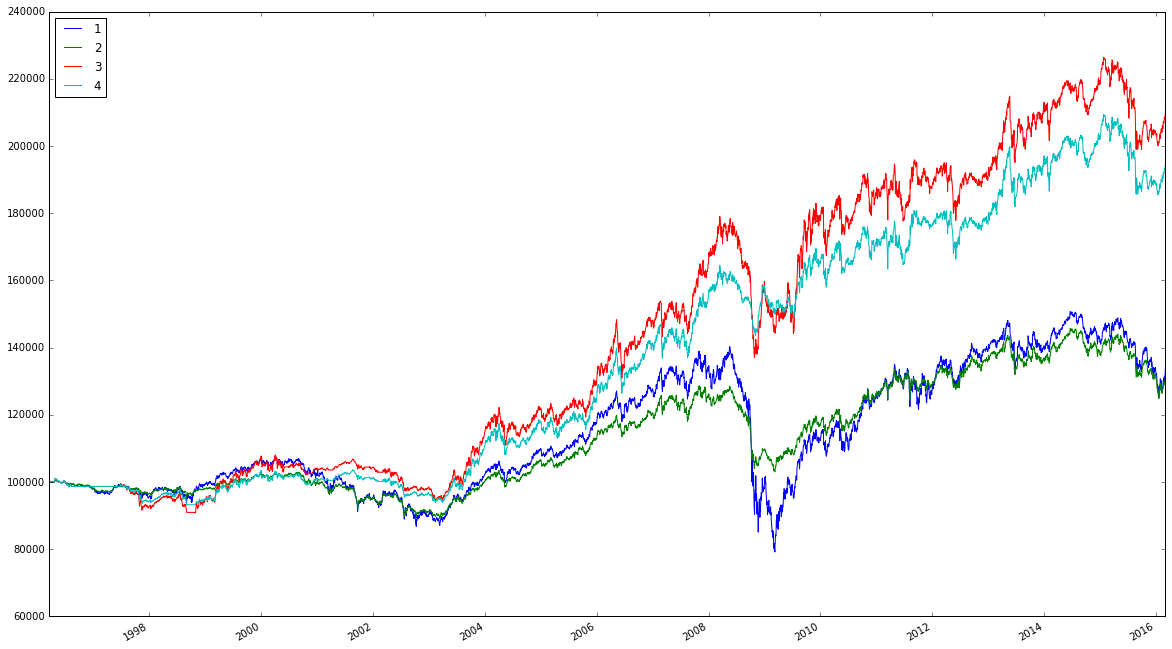

In [487]:
def portfolio_4(returns): 
    mom = returns.sum(axis=1)
    wt = (mom > np.median(mom)) * 0.2
    return np.asarray(wt)

def initialize(context):
    add_history(120, '1d', 'price') 
    set_slippage(slippage.FixedSlippage(spread=0.0)) 
    set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0)) 
    context.tick = 0
    
def handle_data(context, data): 
    rebalance_period = 20
    
    context.tick += 1 
    if context.tick % rebalance_period != 0:
        return 
    
    
    # Get rolling window of past prices and compute returns 
    prices_6m = history(120, '1d', 'price').dropna() 
    returns_6m = prices_6m.pct_change().dropna() 
    prices_60d = history(60, '1d', 'price').dropna()
    returns_60d = prices_60d.pct_change().dropna()
    
    
    
    try: 
        # Get the strongest 5 in momentum
        mom = returns_6m.T.sum(axis=1)
        selected = (mom > np.median(mom)) * 1

        # 60 days volatility 
        vol = np.std(returns_60d.T, axis=1)
        vol_target = 0.01
        wt = vol_target / vol * 0.2
        wt[wt > 0.2] = 0.2
        #
        weights = wt * selected
        # Rebalance portfolio accordingly 
        for stock, weight in zip(prices_60d.columns, weights): 
            order_target_percent(stock, weight) 
    except ValueError as e: 
        # Sometimes this error is thrown 
        # ValueError: Rank(A) < p or Rank([P; A; G]) < n 
        pass

    
# Instantinate algorithm 
algo4 = TradingAlgorithm(initialize=initialize, 
                        handle_data=handle_data) 
# Run algorithm 
results = algo4.run(dp.dropna())
ret_ports[4] = results.portfolio_value
ret_ports.plot(figsize=[20,12])

## Portfolio 5: Minimize Vol 
construct a portfolio with the minimal vol. 

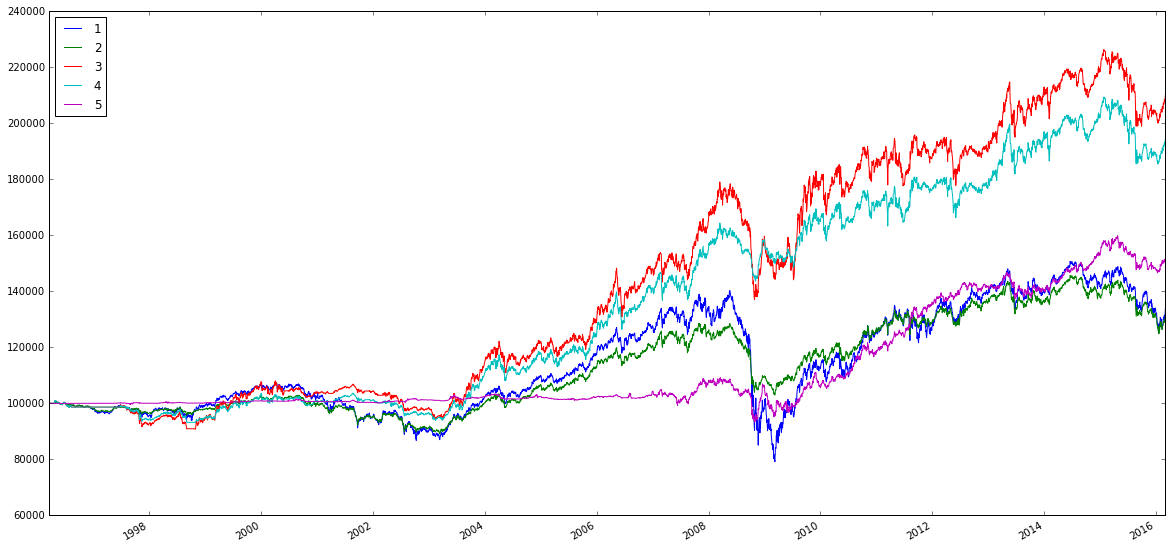

In [488]:
from cvxpy import *

def minimize_vol(returns): 
    n = len(returns) 
    w  = Variable(n)

    gamma = Parameter(sign='positive')
    mu = returns.mean(axis=1)
    ret = np.array(mu)[np.newaxis] * w
    
    Sigma = np.cov(returns)
    risk = quad_form(w, Sigma)
    prob = Problem(Maximize(ret - 200*risk), [sum_entries(w)==1, w >=0])
    prob.solve()
    #print w.value.T * Sigma * w.value
    return np.asarray(w.value)

def initialize(context):
    add_history(120, '1d', 'price') 
    set_slippage(slippage.FixedSlippage(spread=0.0)) 
    set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0)) 
    context.tick = 0

def handle_data(context, data): 
    rebalance_period = 20

    context.tick += 1 
    if context.tick < 120 : 
        return
    if context.tick % rebalance_period != 0:
        return 


    # Get rolling window of past prices and compute returns 
    prices_6m = history(120, '1d', 'price').dropna() 
    returns_6m = prices_6m.pct_change().dropna() 
    prices_60d = history(60, '1d', 'price').dropna()
    returns_60d = prices_60d.pct_change().dropna()



    try: 
        # Get the strongest 5 in momentum
        mom = returns_6m.T.sum(axis=1)
        #selected_indices = mom[mom>0].order().tail(len(mom) /2).index
        selected_indices = mom.index
        #selected_indices = mom[mom > 0 ].index
        selected_returns = returns_60d[selected_indices]
        
        weights = minimize_vol(selected_returns.T)
#         weights = minimize_vol(returns_60d.T)
        # Rebalance portfolio accordingly 
        for stock, weight in zip(selected_returns.columns, weights): 
            order_target_percent(stock, weight) 
    except : 
        # Sometimes this error is thrown 
        # ValueError: Rank(A) < p or Rank([P; A; G]) < n 
        pass


# Instantinate algorithm 
algo5 = TradingAlgorithm(initialize=initialize, 
                        handle_data=handle_data) 
# Run algorithm 
results = algo5.run(dp.dropna())
ret_ports[5] = results.portfolio_value
ret_ports.plot(figsize=[20,10])


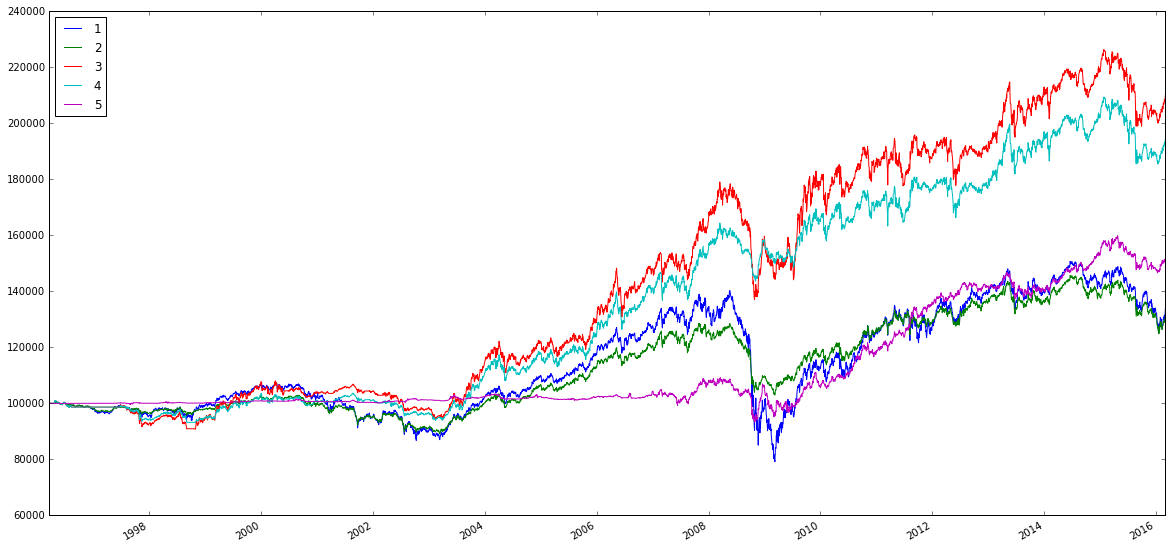

In [489]:
ret_ports = ret_ports.dropna()
ret_ports.plot(figsize=[20,10])

### 弥财配置
我们现在试一试弥财选中的几个ETF， 是否可以通过同样的方法， 构建一个回报更高的投资组合

In [490]:
micai_tickers = ['GOOG/NYSE_VWO', 
                'GOOG/NYSE_VPL', 
                'GOOG/NYSE_VGK', 
                'GOOG/NYSE_VTI', 
                'GOOG/NYSE_IYR']
data  = TimeSeries(Settings()).get_agg_data(micai_tickers)
data = data.fillna(method='pad', axis=0)
data = data.fillna(method='bfill', axis=0)
data = data.dropna()

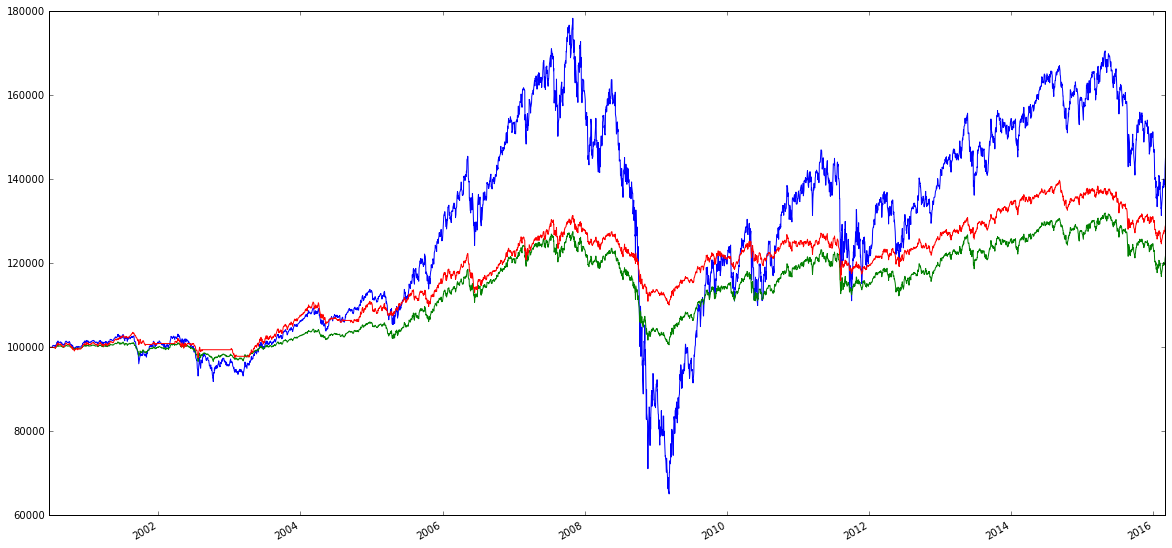

In [493]:
algo = TradingAlgorithm(initialize=initialize, 
                        handle_data=handle_data) 
# Run algorithm 
results = algo1.run(data)
results.portfolio_value.plot(figsize=[20,10])

algo2.run(data).portfolio_value.plot(figsize=[20,10])
algo4.run(data).portfolio_value.plot(figsize=[20,10])

# Correlation Checking

In [423]:

def avg_corr(returns, size=20) :
    corrs = pd.rolling_corr(returns, 100)
    corrs = corrs.dropna()
    n = corrs.shape[1]
    avg_corr = (corrs.sum().sum() - n)/(n*(n-1))
    return avg_corr

df = pd.DataFrame()
df['ret'] = df_rets['GOOG/NYSE_SPY']
df['nav'] = (1+df['ret']).cumprod()
df['avg_corr'] = avg_corr(df_rets, 60)
df['ma_corr'] = pd.rolling_mean(df['avg_corr'], 30)
df['vol'] = pd.rolling_std(df['ret'], 60)*10
df['ma_vol'] = pd.rolling_mean(df['vol'], 20)
df = df.dropna()

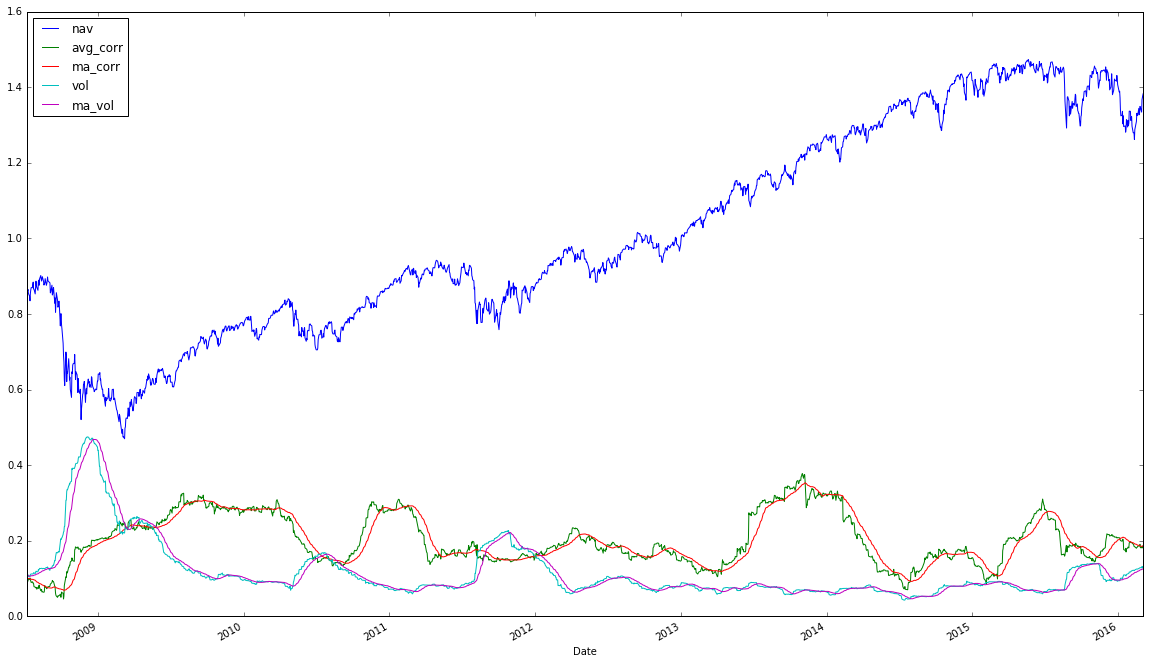

In [424]:
df[['nav', 'avg_corr', 'ma_corr', 'vol', 'ma_vol']].plot(figsize=[20,12])

In [432]:
df[['nav', 'avg_corr', 'vol']].pct_change().corr()

,nav,avg_corr,vol
nav,1.000000,-0.008830,-0.050543
avg_corr,-0.008830,1.000000,0.053062
vol,-0.050543,0.053062,1.000000


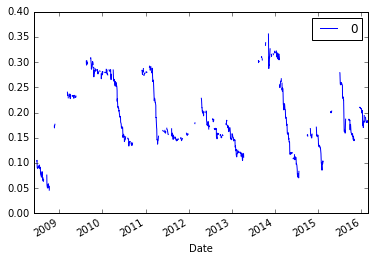

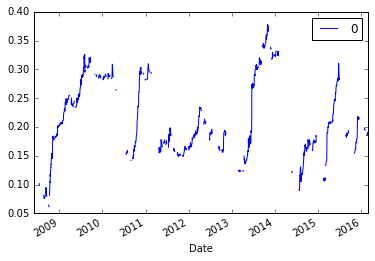

In [390]:
avg_corr = pd.DataFrame(avg_corr)
avg_corr[avg_corr < pd.rolling_median(avg_corr, 20)].plot()
avg_corr[avg_corr > pd.rolling_median(avg_corr, 20)].plot()

KeyboardInterrupt: 

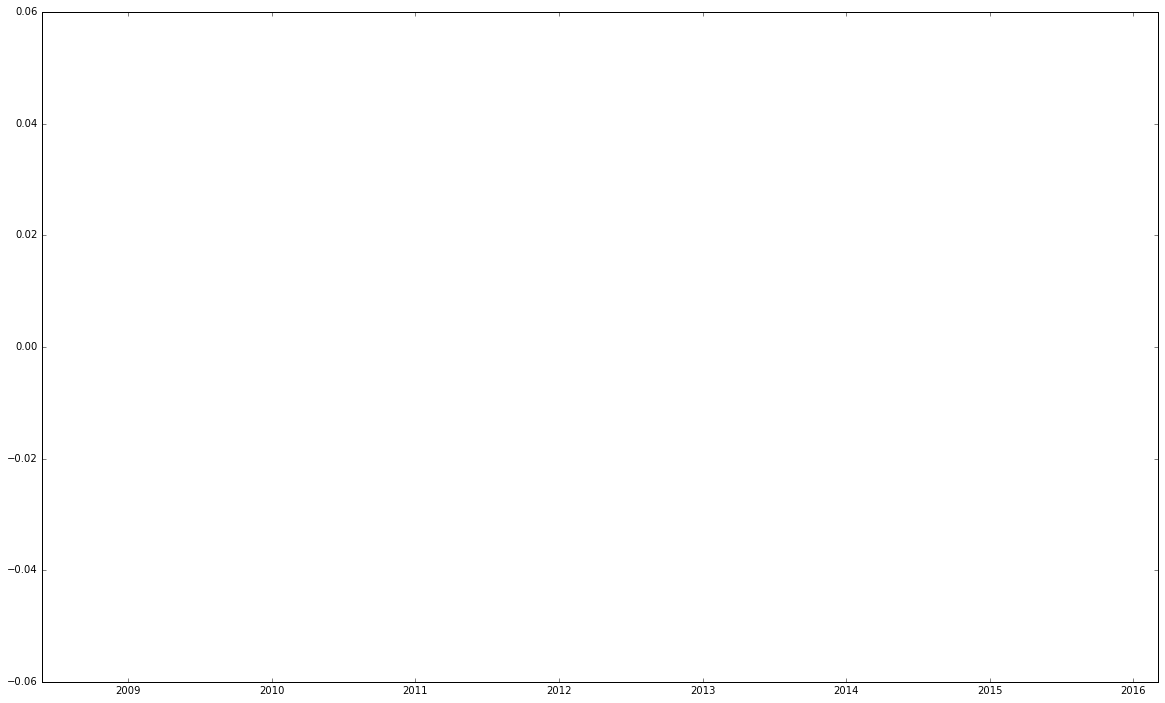

In [403]:
df_rets_low_corr = df_rets['GOOG/NYSE_SPY'] * (avg_corr < pd.rolling_median(avg_corr, 20))
df_rets_high_corr = df_rets['GOOG/NYSE_SPY'] * (avg_corr > pd.rolling_median(avg_corr, 20))

(1+df_rets_low_corr).cumprod().plot(figsize=[20,12])
(1+df_rets_high_corr).cumprod().plot(figsize=[20,12])

In [398]:
avg_corr < pd.rolling_median(avg_corr, 20)

,0
Date,
2008-05-27 00:00:00+00:00,False
2008-05-28 00:00:00+00:00,False
2008-05-29 00:00:00+00:00,False
2008-05-30 00:00:00+00:00,False
2008-06-02 00:00:00+00:00,False
2008-06-03 00:00:00+00:00,False
2008-06-04 00:00:00+00:00,False
2008-06-05 00:00:00+00:00,False
2008-06-06 00:00:00+00:00,False


In [364]:
(1+df_rets[avg_corr < avg_corr.median(), 'GOOG/NYSE_SPY']).cumprod().plot(figsize=[20, 10])

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [ ]:
# returns_6m = df_rets[-120::]
returns_60d = df_rets[-60::]
mu = returns_60d.T.mean(axis=1)
print mu
mom = returns_6m.T.sum(axis=1)
selected_indices = mom.order().tail(len(mom) /2).index
selected_returns = returns_60d[selected_indices]

# 60 days volatility 


returns = selected_returns.T

n = len(returns) 
w  = Variable(n)

gamma = Parameter(sign='positive')
mu = returns.mean(axis=1)
ret = np.array(mu)[np.newaxis] * w

Sigma = np.cov(returns)
risk = quad_form(w, Sigma)
prob = Problem(Maximize(ret - 2*risk), [sum_entries(w)==1, w >=0])
prob.solve()
print w.value.T * Sigma * w.value

In [ ]:
np.array(mu)[np.newaxis]

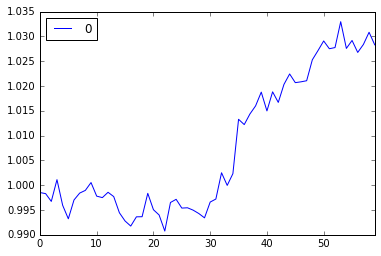

In [85]:
rets = (1+np.dot(selected_returns_60, weights)).cumprod()
pd.DataFrame(rets).plot()

In [23]:
a = np.array(df_rets) *  np.array(selected)[np.newaxis]


50390

In [339]:
returns = df_ret[3000:3500].T
n = len(returns) 
returns = np.asmatrix(returns) 


# # Convert to cvxopt matrices 
S = opt.matrix(np.cov(returns)) 
pbar = opt.matrix(0.0, (n, 1)) 

# # Create constraint matrices 
G = -opt.matrix(np.eye(n)) # negative n x n identity matrix 
h = opt.matrix(0.0, (n ,1)) 


b = np.array(selected)
c = np.array(range(10)) * (selected <>0)
d = c[c<>0]

A = np.eye(10)
A = A[d, :]
A = np.vstack([np.ones((1, n)), A])
A = opt.matrix(A)

b = np.zeros((len(d), 1))
b = np.vstack([1.0, b])
b = opt.matrix(b)


np.rank(A)

wt = solvers.qp(S, -pbar, G, h, A, b)['x'] 
# print wt
# return np.asarray(wt)



     pcost       dcost       gap    pres   dres
 0:  1.3128e-04 -1.0002e+00  1e+01  3e+00  4e+00
 1:  1.3135e-04 -6.9791e-01  8e-01  3e-02  4e-02
 2:  1.3129e-04 -8.4437e-03  9e-03  3e-04  4e-04
 3:  1.2596e-04 -2.4293e-04  4e-04  1e-05  2e-05
 4:  3.0243e-05 -7.0158e-05  1e-04  1e-07  2e-07
 5:  2.0517e-05  1.1518e-05  9e-06  5e-09  7e-09
 6:  1.9443e-05  1.8576e-05  9e-07  3e-10  4e-10
 7:  1.9345e-05  1.9242e-05  1e-07  3e-11  3e-11
 8:  1.9335e-05  1.9329e-05  6e-09  3e-13  3e-13
Optimal solution found.


In [341]:
print wt


[ 1.72e-02]
[ 9.42e-02]
[ 1.12e-27]
[ 7.89e-01]
[-1.15e-28]
[ 2.77e-02]
[ 1.34e-27]
[ 7.17e-02]
[ 3.66e-27]
[ 1.47e-27]



In [295]:

print b

[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]


In [293]:
np.ones((5, 1))

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.]])

In [ ]:

def optimal_portfolio(returns): 
    n = len(returns) 
    returns = np.asmatrix(returns) 
    N = 100 
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)] 
    
    # Convert to cvxopt matrices 
    S = opt.matrix(np.cov(returns)) 
    pbar = opt.matrix(np.mean(returns, axis=1)) 
    
    # Create constraint matrices 
    G = -opt.matrix(np.eye(n)) # negative n x n identity matrix 
    h = opt.matrix(0.0, (n ,1)) 
    A = opt.matrix(1.0, (1, n)) 
    b = opt.matrix(1.0) 
    
    # Calculate efficient frontier weights using quadratic programming 
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus] 
    
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER 
    returns = [blas.dot(pbar, x) for x in portfolios] 
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios] 
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE 
    m1 = np.polyfit(returns, risks, 2) 
    x1 = np.sqrt(m1[2] / m1[0]) 
    # CALCULATE THE OPTIMAL PORTFOLIO 
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x'] 
    return np.asarray(wt), returns, risks 



In [338]:
returns = df_ret[3000:3500].T

n = len(returns) 
returns = np.asmatrix(returns) 
N = 100 
mus = [10**(5.0 * t/N - 1.0) for t in range(N)] 

# Convert to cvxopt matrices 
S = opt.matrix(np.cov(returns)) 
pbar = opt.matrix(np.mean(returns, axis=1)) 

# Create constraint matrices 
G = -opt.matrix(np.eye(n)) # negative n x n identity matrix 
h = opt.matrix(0.0, (n ,1)) 
A = opt.matrix(1.0, (1, n)) 
b = opt.matrix(1.0)

# Calculate efficient frontier weights using quadratic programming 
portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus] 

## CALCULATE RISKS AND RETURNS FOR FRONTIER 
returns = [blas.dot(pbar, x) for x in portfolios] 
risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios] 
## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE 
m1 = np.polyfit(returns, risks, 2) 
x1 = np.sqrt(m1[2] / m1[0]) 
# CALCULATE THE OPTIMAL PORTFOLIO 
wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x'] 

     pcost       dcost       gap    pres   dres
 0:  1.6302e-04 -1.0005e+00  1e+00  6e-17  3e+00
 1:  1.6272e-04 -1.0508e-02  1e-02  6e-17  4e-02
 2:  1.3629e-04 -6.0725e-04  7e-04  7e-17  3e-03
 3: -4.3566e-04 -9.1319e-04  5e-04  2e-16  8e-04
 4: -4.8011e-04 -4.9180e-04  1e-05  5e-17  2e-05
 5: -4.8746e-04 -4.8758e-04  1e-07  5e-18  2e-07
 6: -4.8754e-04 -4.8754e-04  1e-09  3e-17  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.6448e-04 -1.0005e+00  1e+00  3e-16  3e+00
 1:  1.6417e-04 -1.0509e-02  1e-02  1e-16  4e-02
 2:  1.3765e-04 -6.0785e-04  7e-04  6e-17  3e-03
 3: -4.3239e-04 -9.1345e-04  5e-04  5e-16  8e-04
 4: -4.7787e-04 -4.9002e-04  1e-05  2e-16  2e-05
 5: -4.8566e-04 -4.8578e-04  1e-07  1e-16  2e-07
 6: -4.8573e-04 -4.8573e-04  1e-09  2e-16  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.6611e-04 -1.0005e+00  1e+00  4e-16  3e+00
 1:  1.6580e-04 -1.0509e-02  1e-02  1e-16  4e-02
 2:  1.3917e-04 -6.0851e

In [335]:
solvers.qp(mus[1]*S, -pbar, G, h, A, b)['x']

ValueError: Rank(A) < p or Rank([P; A; G]) < n

In [337]:
n

4540